# Dots and Boxes

*Jeffrey Buehler & Bobby Signor*
$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

## Background

Our goal for this project was to create an AI capable of beating a random opponent at a game called Dots and Boxes at least 80% of the time, using reinforcement learning techniques.

### The Game

Dots and Boxes is a simple game for two players. The gameboard consists of a grid of an abitrary size. For this project, we chose to fix the size of the board to 5 x 5 boxes.
<figure>
    <img src="img/0-empty.png">
    <figcaption>
        <div style="text-align: center">**Fig. 1.1:** An empty 5 x 5 board.</div>
    </figcaption>
</figure>

Each player switches off taking turns. A turn starts with the player drawing a line between two adjacent unconnected dots. If the new line the player draws does not complete a 1 x 1 square, then that player's turn is over and it is the other player's turn.
<figure>
    <img src="img/fig2.png">
    <figcaption>
        <div style="text-align: center">**Fig. 1.2:** An example of a player taking a turn and not completing a box.</div>
    </figcaption>
</figure>

However, if the player draws a line that does complete a 1 x 1 square, the player is rewarded a point for that box and gets to draw another line, with the above rule still in place.
<figure>
    <img src="img/fig3.png">
    <figcaption>
        <div style="text-align: center">**Fig. 1.3:** An example of a player drawing a line, completing a box, and then drawing another line.</div>
    </figcaption>
</figure>

The game ends when it is no longer possible to draw another line. The winner is determined by whoever has the most boxes at the end of the game. In the example game shown in Figure 1.4, player X would be the winner.
<figure>
    <img src="img/fig4.png">
    <figcaption>
        <div style="text-align: center">**Fig. 1.4:** An example of a board after a game's been completed. Here, player X has 16 points, while player O has 9.</div>
    </figcaption>
</figure>

#### A Simple Strategy

While the objective of the game is to score more points than your opponent, it is not always wise to complete boxes as quickly as possible. One strategy that is quickly learned by human opponents is creating paths that can eventually be completed without giving your opponent a chance to counter, as shown in Figure 1.3. When used correctly, this strategy maximizes the number of points earned by reducing the number of opportunities your opponent has to draw lines. However, this must be done with care, since your opponent may also take the opportunity to complete your path and steal those points from you.
<figure>
    <img src="img/fig5.png">
    <figcaption>
        <div style="text-align: center">**Fig. 1.5:** An example of a board setup that would net a single player 9 points before the other player can take their turn.</div>
    </figcaption>
</figure>

## Implementation

### Game

The Game object contains the complete state of the game and the logic required to correctly play it. Initializing it and starting a new game is as follows:

```python
g = Game()
g.play(player1, player2)
``` 

### Players

We have created 2 different kinds of players for our game:

1. **Random Player:** This player chooses moves simply by randomly choosing any of the available moves at random each time it's asked. Its play does not improve as it plays more games.
 
2. **AI Player:** This player uses reinforcement learning techniques (see below) to learn which move given a board state is most likely to result in a win, and choosing that one. We can also have it make some of its moves randomly for training by specifying the probability it takes a random move in a parameter called epsilon. While training, we start epsilon at 1 and steadily decay that number as the AI Player is exposed to more board states and more games.

## The Machine Learning Method: Reinforcement Programming

### Reinforcement Learning

Reinforcement learning is a method of machine learning used to teach a program to give correct output given input using reward/punishment. The behavior of a reinforced program is based on the psychological response of humans trying to suceed at a task. One way to picture this is to imagine a child being taught how to read by a grade-school teacher. They are presented with simple words and are asked to sound out the word. If presented incorrectly, the teacher will inform the child they were wrong and give feedback on how to improve. If the child pronounces the word correctly, they are given positive feedback, and sometimes some sort of reward. Eventually, the child will learn that certain letters interact with others in certian ways because they were given positive reinforcement when they did something correct.

### Applied to AI Player

We will be applying reinforcement learning to our AI Player. It will be reinforced depending on the moves it makes that end up winning a game. Positive reinforcement will be given whenever the AI is able to win a game. The decisions the AI makes will be determined on past experience of winning moves.

### Hypothesis

We believe if we train the AI enough, it will be able to defeat a random opponent easily. If we train it against another AI, it will be able to learn more sensible moves to make. We also believe that if trained against a human opponent, it will eventually learn the strategies talked about earlier that humans are able to do.

In [1]:
# External Game & Player Code
import game
import players

# Graphing
%pylab inline
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import IPython.display as ipd

# Misc.
import time
import copy

Populating the interactive namespace from numpy and matplotlib


## Graphing Functions

The folliowing functions allow us to visually show our results.

In [2]:
def graph_all(board):
    graph_board(board)

def graph_epsilon():
    return 0

def graph_board(board):
    plt.plot(board.shape[1] - 1, board.shape[1] - 1)
    plt.xlim(-1,board.shape[1])
    plt.ylim(-1,board.shape[1])
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    
    for r in range(board.shape[0]):
        for c in range(board.shape[1]):
            x = None
            if board[r, c] == True:
                if r % 2 == 0:
                    if c < 5:
                        x, y = [c, c + 1], [int(r / 2), int(r / 2)]
                else:
                    x, y = [c, c], [int(r / 2), int(r / 2) + 1]
                if x is not None:
                    plt.plot(x, y, color="#000000")
    
    for i in range(board.shape[1]):
        for j in range(board.shape[1]):
            plt.scatter(i, j)

def graph_win_percentage(winPercent, graphTitle):
    pointsToPlotPercent = .01
    frames = int(len(winPercent) * pointsToPlotPercent)
    for key, value in winPercent.items():
        if frames is 0:
            plt.scatter(key, value, marker='.')
        elif (key % frames == 0):
            plt.scatter(key, value, marker='.')
    plt.xlim(0, len(winPercent))
    plt.ylim(0, 1)
    x, y = [0, len(winPercent)], [.5, .5]
    plt.plot(x, y, color="r")
    xlabel('Games')
    ylabel('Win (%)')
    title(graphTitle)
    print("Final Win Rate: ", winPercent[len(winPercent) - 1])

## Control: RandomPlayer vs. RandomPlayer

For our control, we pit 2 RandomPlayers against each other to see the results and make sure that there's no inherent advantage that we haven't forseen (such as first move advantage).

Random vs. Random: 1001 wins to 999 wins (2000 games total).
Took 3.2265446186065674 seconds.
Final Win Rate:  0.5005


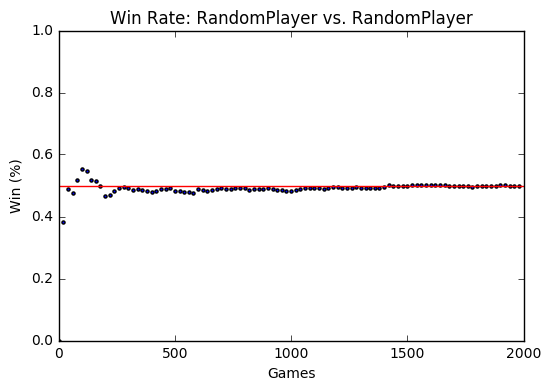

In [3]:
chaosIterations = 2000
start = time.time()
wins = [0, 0]
winRecordTracker = {}
p1 = players.RandomPlayer()
p2 = players.RandomPlayer()

for i in range(chaosIterations):
    g = game.Game()
    g.play(p1, p2)
    wins[g.score.index(max(g.score))] += 1
    winRecordTracker[i] = wins[0] / (i + 1)

print("Random vs. Random: {} wins to {} wins ({} games total).".format(wins[0], wins[1], chaosIterations))
print("Took", time.time() - start, "seconds.")
graph_win_percentage(winRecordTracker, "Win Rate: RandomPlayer vs. RandomPlayer")

#### Observations

We can see that win percentages remain roughly around 50%, which was expected when two players simply choosing random moves go against each other. This indicates that we were correct in assuming that there aren't any outside factors that impact the result.

## Experiments

### Helper Functions

To make it easier to perform our experiments, we made several helper functions that we could reuse across multiple tests. The first 2 are functions that allow us to easily train and test an AIPlayer against a RandomPlayer.

In [3]:
def trainVsRandom(aiPlayer, randPlayer, iterations, epsilonDecay):
    # Initialize Variables
    start = time.time()
    aiWins = 0
    winPercent = {}
    # Configure AIPlayer
    aiPlayer.train = True
    for i in range(iterations):
        g = game.Game()
        if i % 2 is 0:
            g.play(aiPlayer, randPlayer)
        else:
            g.play(randPlayer, aiPlayer)
        if g.score.index(max(g.score)) is aiPlayer.playernum:
            aiWins += 1
        winPercent[i] = aiWins / (i + 1)
        aiPlayer.epsilon *= epsilonDecay
    print("Training AIPlayer vs. RandomPlayer")
    print("Final Score:\tAI: {} wins.\tRandom: {} wins.".format(aiWins, iterations - aiWins))
    print("Completed in {} seconds.\n".format(time.time() - start))
    return winPercent

def testVsRandom(aiPlayer, randPlayer, iterations):
    # Initialize Variables
    start = time.time()
    aiWins = 0
    winPercent = {}
    # Configure AIPlayer
    aiPlayer.train = False
    for i in range(iterations):
        g = game.Game()
        if i % 2 is 0:
            g.play(aiPlayer, randPlayer)
        else:
            g.play(aiPlayer, randPlayer)
        if g.score.index(max(g.score)) is aiPlayer.playernum:
            aiWins += 1
        winPercent[i] = aiWins / (i + 1)
    print("Testing AIPlayer vs. RandomPlayer")
    print("Final Score:\tAI: {} wins.\tRandom: {} wins.".format(aiWins, iterations - aiWins))
    print("Completed in {} seconds.\n".format(time.time() - start))
    return winPercent

The last 2 functions allow us to easily train and test AIPlayers against each other.

In [4]:
def trainVsAi(ai1, ai2, iterations, epsilonDecay):
    # Initialize Variables
    start = time.time()
    ai1Wins = 0
    winPercent = {}
    # Configure AIPlayers
    ai1.train = True
    ai2.train = True
    for i in range(iterations):
        g = game.Game()
        if i % 2 is 0:
            g.play(ai1, ai2)
        else:
            g.play(ai2, ai1)
        if g.score.index(max(g.score)) is ai1.playernum:
            ai1Wins += 1
        p1.epsilon *= epsilonDecay
        p2.epsilon *= epsilonDecay
        winPercent[i] = ai1Wins / (i + 1)
    print("Training AIPlayer vs. AIPlayer")
    print("Final Score:\tAI: {} wins.\tRandom: {} wins.".format(aiWins, iterations - aiWins))
    print("Completed in {} seconds.\n".format(time.time() - start))
    return winPercent

def testVsAi(ai1, ai2, iterations):
    start = time.time()
    ai1.train = False
    ai2.train = False
    ai1Wins = 0
    winPercent = {}
    for i in range(iterations):
        g = game.Game()
        if i % 2 is 0:
            g.play(ai1, ai2)
        else:
            g.play(ai2, ai1)
        if g.score.index(max(g.score)) is ai1.playernum:
            ai1Wins += 1
        winPercent[i] = ai1Wins / (i + 1)
    print("Testing AIPlayer vs. AIPlayer")
    print("Final Score:\tAI: {} wins.\tRandom: {} wins.".format(aiWins, iterations - aiWins))
    print("Completed in {} seconds.\n".format(time.time() - start))
    return winPercent

### Experiment 1: Learning from Chaos

#### Description
Our first test is to simply train an AIPlayer against a RandomPlayer over 2,000 iterations, and then see how well that AIPlayer performs against the same opponent after training.

#### Hypothesis
We believe the AIPlayer will quickly learn how to play against the RandomPlayer after a little while, ending up with a final win rate of over 80% after 2,000 iterations. There will still be random instances of losses, even after a few thousand games played, but the AIPlayer will be victorious in all the others.

In [6]:
trainIterations = 2000
testIterations = 200
rho = 0.2
initialEpsilon = 1.0
epsilonDecay = 0.99

p1 = players.AIPlayer(rho=rho, epsilon=initialEpsilon)
p2 = players.RandomPlayer()

Training AIPlayer vs. RandomPlayer
Final Score:	AI: 1957 wins.	Random: 43 wins.
Completed in 6.031030654907227 seconds.

Final Win Rate:  0.9785


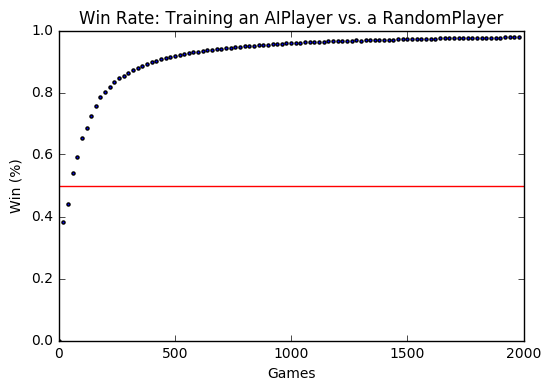

In [7]:
winrateTrain = trainVsRandom(p1, p2, trainIterations, epsilonDecay)
graph_win_percentage(winrateTrain, "Win Rate: Training an AIPlayer vs. a RandomPlayer")

Testing AIPlayer vs. RandomPlayer
Final Score:	AI: 200 wins.	Random: 0 wins.
Completed in 0.5692107677459717 seconds.

Final Win Rate:  1.0


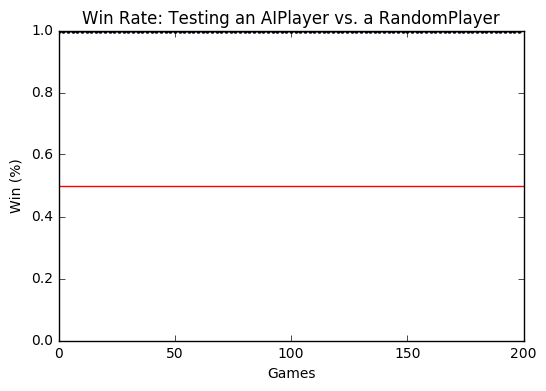

In [8]:
p1.epsilon = 0.01
winrateTest = testVsRandom(p1, p2, testIterations)
graph_win_percentage(winrateTest, "Win Rate: Testing an AIPlayer vs. a RandomPlayer")

#### Obserations

The data clearly shows that using reinforcement versus a random player will result in consistent wins after far fewer than 500 games played in training. Applying the information AIPlayer learned during that training process against a fresh opponent and with the training and epsilon decay features disabled, the AI was able to win almost every single game against another RandomPlayer. This is very impressive to us, as we expected it to take far more iterations to reach our goal of 80%, never mind an almost perfect win rate.

### Experiment 2: The Same, but More

#### Description

We decided to increase the number of training games played between the AIPlayer and the RandomPlayer to see if that had any impact on the final win rate, the concern being that we would see adverse affects due to overtraining. Training iteration counts were multiplied by 10 compared to Experiment 1. Nothing else was changed, aside from the random number generator seeds.

#### Hypothesis

AIPlayer will learn at the same rate as it did in Experiment 1, and will eventually reach an approximately 100% win rate in training far before completing 20,000 iterations, with no adverse affects from overtraining.

In [9]:
trainIterations = 20000
testIterations = 200
rho = 0.2
initialEpsilon = 1.0
epsilonDecay = 0.99

p1 = players.AIPlayer(rho=rho, epsilon=initialEpsilon)
p2 = players.RandomPlayer()

Training AIPlayer vs. RandomPlayer
Final Score:	AI: 19919 wins.	Random: 81 wins.
Completed in 63.61847138404846 seconds.

Final Win Rate:  0.99595


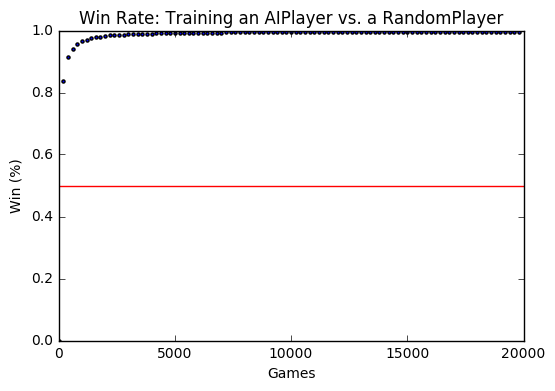

In [10]:
winrateTrain = trainVsRandom(p1, p2, trainIterations, epsilonDecay)
graph_win_percentage(winrateTrain, "Win Rate: Training an AIPlayer vs. a RandomPlayer")

Testing AIPlayer vs. RandomPlayer
Final Score:	AI: 200 wins.	Random: 0 wins.
Completed in 0.5561952590942383 seconds.

Final Win Rate:  1.0


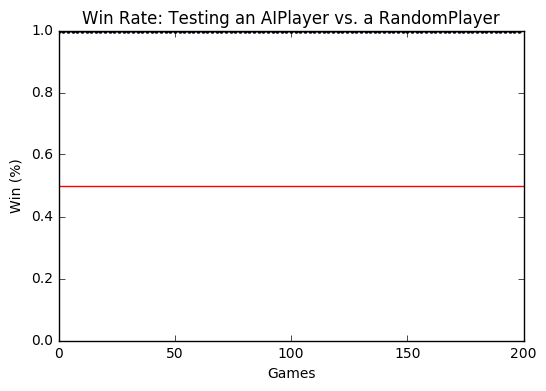

In [11]:
winrateTest = testVsRandom(p1, p2, testIterations)
graph_win_percentage(winrateTest, "Win Rate: Testing an AIPlayer vs. a RandomPlayer")

#### Observations

Our hypothesis for this experiment was correct: training over 20,000 iterations did not give us any adverse affects related to overtraining. However, since we already started at a win rate of approximately 100%, these results do not indicate any significant changes.

### Experiment 3: Making Things Worse

#### Description

Now that we've proven we can reliably beat a RandomPlayer, it's time to figure out what it takes to negatively impact the win rate. Here, we've increased the number of testing iterations to 1,000, while dropping the number of training iterations dramatically. Our objective was to see what it took to get the win rate down to 80%, our original target.

#### Hypothesis

We expect that we'll need to drop to around 200 iterations to get the win rate down to 80%.

In [5]:
trainIterations = 75
testIterations = 1000
rho = 0.2
initialEpsilon = 1.0
epsilonDecay = 0.99

p1 = players.AIPlayer(rho=rho, epsilon=initialEpsilon)
p2 = players.RandomPlayer()

Training AIPlayer vs. RandomPlayer
Final Score:	AI: 44 wins.	Random: 31 wins.
Completed in 0.24416065216064453 seconds.

Final Win Rate:  0.5866666666666667


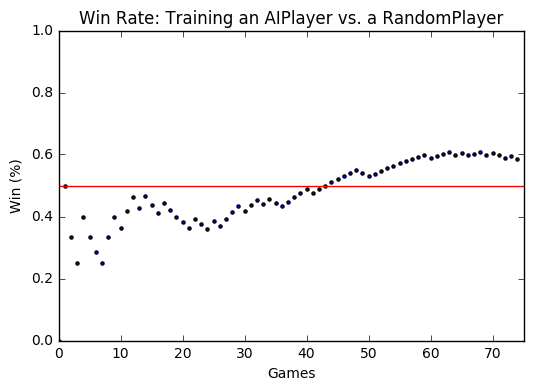

In [6]:
winrateTrain = trainVsRandom(p1, p2, trainIterations, epsilonDecay)
graph_win_percentage(winrateTrain, "Win Rate: Training an AIPlayer vs. a RandomPlayer")

Testing AIPlayer vs. RandomPlayer
Final Score:	AI: 759 wins.	Random: 241 wins.
Completed in 3.271271228790283 seconds.

AIPlayer Epsilon: 0.47058664158564995
Final Win Rate:  0.759


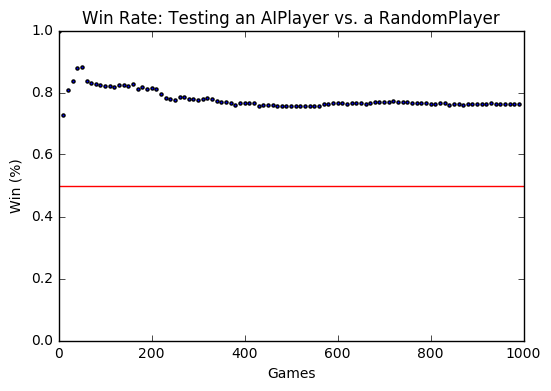

In [7]:
winrateTest = testVsRandom(p1, p2, testIterations)
print("AIPlayer Epsilon:", p1.epsilon)
graph_win_percentage(winrateTest, "Win Rate: Testing an AIPlayer vs. a RandomPlayer")

#### Observations

After testing, we discovered that around 75 iterations would give us around an 80% win rate, 125 iterations lower than our initial estimate. This suggests that this game is extremely easy to learn, our RandomPlayer is extremely easy to play against, or both. In addition, since we decayed the probability that the AIPlayer would take a random move at a fixed rate, rather than setting start and end values, the lower we set the number of iterations, the more random moves the AIPlayer would end up taking. And yet the AIPlayer consistently ends up with a winrate of around 80%, despite taking almost 50% of its moves randomly.

### Experiment 3A: Making the Bad Better

#### Description

As discussed in the observations section of Experiment 3, our trained AIPlayer was taking almost half of its turns randomly. In this experiment, we tested what would happen if we tested the same AIPlayer but with an epsilon value of 0.01 (approximately 1 random selection every 100 turns).

#### Hypothesis

We expect the win rate to be greater than it was previously due to a greater reliance on the AIPlayer's training.

Testing AIPlayer vs. RandomPlayer
Final Score:	AI: 996 wins.	Random: 4 wins.
Completed in 3.8226680755615234 seconds.

Final Win Rate:  0.996


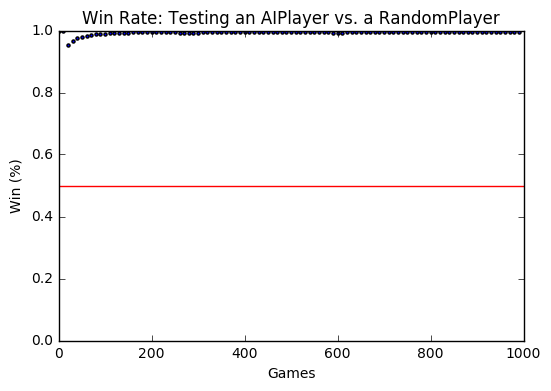

In [8]:
p1.epsilon = 0.01
winrateTest = testVsRandom(p1, p2, testIterations)
graph_win_percentage(winrateTest, "Win Rate: Testing an AIPlayer vs. a RandomPlayer")

#### Observations

We did not expect to be seeing a final win rate of nearly 100%. Considering how little training was done, this is likely indicative of how bad RandomPlayer truly is at this game.

### Experiment 4: First Available Spot

#### Description

AIPlayer decides its next move based on a random chance variable (epsilon) and data that exists in a Q dictionary that is populated through reinforcement learning. If two next moves probabilities are equal when choosing a next move based on the Q dictionary, it will simply choose the first value. The first value is whatever free move is available starting from the top left of the board, moving to the right and down. How often would a player that only choses the first available position win against a player that choses lines at random?

For this experiment, we will not do any training for AIPlayer, as this is AIPlayer's default behavior when faced with a board state it does not recognize. It will just run tests versus RandomPlayer. Also, epsilon will start at 0 so that there are no random moves made by AIPlayer.

#### Hypothesis

We believe that AIPlayer will actually win more than lose, since completing the map from one side to the other is bound to fill out more squares as it goes. I do not think that the win rate will be 75% or higher, but we think it will be slightly higher than average, maybe around 60%.

In [42]:
trainIterations = 0
testIterations = 100
rho = 0.2
initialEpsilon = 0.0
epsilonDecay = 0.99

p1 = players.AIPlayer(rho=rho, epsilon=initialEpsilon)
p2 = players.RandomPlayer()

Testing AIPlayer vs. RandomPlayer
Final Score:	AI: 100 wins.	Random: 0 wins.
Completed in 0.2663302421569824 seconds.

Final Win Rate:  1.0


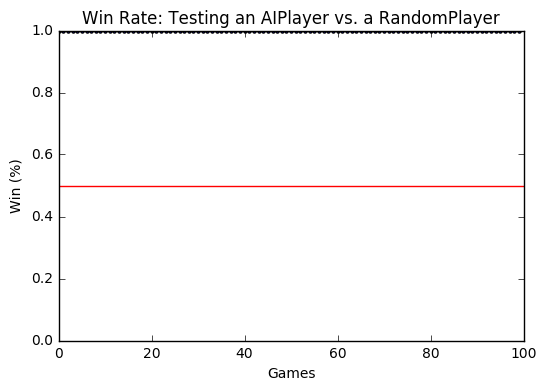

In [43]:
winrateTest = testVsRandom(p1, p2, testIterations)
graph_win_percentage(winrateTest, "Win Rate: Testing an AIPlayer vs. a RandomPlayer")

In [45]:
p1.Q

{}

#### Observations

This is very remarkable. None of us foresaw an untrained AIPlayer with an epsilon of 0 getting a near-perfect record, even against a RandomPlayer. 

We know this data is not being trained either, since the Q dictionary for the AIPlayer (where the information it learns is stored) is empty, meaning it has not learned anything and is running on default behavior all the time.

## Conclusion
The game of Dots and Boxes is a very simple game. As we could see from the data in Experiments 1, 2, 3, and 4, it is easy to train a player to win against a random opponent.

### Future Experiments

 - This experiment could be futher studied by running our AIPlayer against other opponents that use different strategies, such as the paths method mentioned earlier or even an opponent that always chooses the first available space to place a line.

 - We could also try to train one Q dictionary using two AIPlayers. This may allow the players to learn more quickly, however each player will more or less know each other's moves and will be able to predict them easier. This may actually result in a smarter AI being able to discover unknown strategies to the game. However, this may result in a much less intelligent AI, since it will not have observed strategies from outside sources, so it would never figure out anything more than what it already knows.
 
 - It would be fun to make an interface that a human could interact with that would use the trained data to play against you. It would also be interesting to see how the AIPlayer would learn when training against a human player. Would it be able to anticipate the strategy behind a human player's choices? If so, would it then become "smarter" than the human, it since it would be able to mathematically analyze a human's strategy? If that were the case, and the AIPlayer was put up against the world's greatest Dots and Boxes player, would it then become greater than them?

Reinforcement learning is a very fascinating topic, and the idea behind programs increasing their abilities in all applied situations, not just in 2 player games, is incredible and will certainly be a major part of the future of computing. It excites us to think that very soon, everyday devices will be able to adapt to human nature to help with all sorts of everyday computing tasks.